# Metric Learning Exercise

In [1]:
import torch
import os
import sys
from mmfashion.datasets import InShopDataset
from mmfashion.datasets.loader import build_dataloader
working_dir = os.getcwd()
sys.path.append(working_dir)
sys.path.append(os.path.join(working_dir, '../siamese-triplet'))

# Prepare datasets

Working with the In-Shop dataset from mmfashion, please check https://github.com/open-mmlab/mmfashion/blob/master/docs/dataset/IN_SHOP_DATASET.md. The code has been changed to adapt to classify based on clothes type and not to image id

In [2]:
img_path = os.path.join(working_dir, '../data/In-shop')
annotations_path = os.path.join(img_path, 'Anno')

In [3]:
batch_size = 64

In [4]:
class_mapping = {
    'Denim': 0,
    'Jackets_Vests': 1,
    'Pants': 2,
    'Shirts_Polos': 3,
    'Shorts': 4,
    'Suiting': 5,
    'Sweaters': 6,
    'Sweatshirts_Hoodies': 7,
    'Tees_Tanks': 8,
    'Blouses_Shirts': 9,
    'Cardigans': 10,
    'Dresses': 11,
    'Graphic_Tees': 12,
    'Jackets_Coats': 13,
    'Leggings': 14,
    'Rompers_Jumpsuits': 15,
    'Skirts': 16
}

train_dataset = InShopDataset(img_path=img_path,
                              img_file=os.path.join(annotations_path,'train_img.txt'),
                              label_file=os.path.join(annotations_path,'train_labels.txt'),
                              id_file=os.path.join(annotations_path,'train_id.txt'),
                              bbox_file=os.path.join(annotations_path,'train_bbox.txt'),
                              landmark_file=os.path.join(annotations_path,'train_landmarks.txt'),
                              img_size=[256, 256],
                              class_mapping=class_mapping)

gallery_dataset = InShopDataset(img_path=img_path,
                              img_file=os.path.join(annotations_path,'gallery_img.txt'),
                              label_file=os.path.join(annotations_path,'gallery_labels.txt'),
                              id_file=os.path.join(annotations_path,'gallery_id.txt'),
                              bbox_file=os.path.join(annotations_path,'gallery_bbox.txt'),
                              landmark_file=os.path.join(annotations_path,'gallery_landmarks.txt'),
                              img_size=[256, 256],
                              class_mapping=class_mapping)

query_dataset = InShopDataset(img_path=img_path,
                              img_file=os.path.join(annotations_path,'query_img.txt'),
                              label_file=os.path.join(annotations_path,'query_labels.txt'),
                              id_file=os.path.join(annotations_path,'query_id.txt'),
                              bbox_file=os.path.join(annotations_path,'query_bbox.txt'),
                              landmark_file=os.path.join(annotations_path,'query_landmarks.txt'),
                              img_size=[256, 256],
                              class_mapping=class_mapping)

train_dataloader = build_dataloader(dataset=train_dataset,
                                    imgs_per_gpu=batch_size,
                                    workers_per_gpu=1,
                                    num_gpus=1,
                                    shuffle=True)

gallery_dataloader = build_dataloader(dataset=gallery_dataset,
                                    imgs_per_gpu=batch_size,
                                    workers_per_gpu=1,
                                    num_gpus=1,
                                    shuffle=True)

query_dataloader = build_dataloader(dataset=query_dataset,
                                    imgs_per_gpu=batch_size,
                                    workers_per_gpu=1,
                                    num_gpus=1,
                                    shuffle=False)

n_classes = 17

# Utils to extract and plot embeddings in low dimensional space

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
cuda = torch.cuda.is_available()
transform = 'TSNE'

mmfashion_classes = [] 
for key in class_mapping.keys(): 
    mmfashion_classes.append(key) 
    
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf', '#1f87b4', '#ff6f0e', '#2cb02c', '#d62728', '#9567bd', '#8c564b', '#e477c2']

def plot_embeddings(embeddings, target, transform=None, xlim=None, ylim=None):
    if len(embeddings) > 2:
        if (transform is 'TSNE'):
            embeddings = TSNE(n_components=2).fit_transform(embeddings)
        elif(transform is 'PCA'):
            pca = PCA(n_components=2)
            pca.fit(embeddings)
            embeddings = pca.transform(embeddings) 
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(target==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mmfashion_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), model.embedding_net.out_dimensions))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for loader in dataloader:
            images = loader['img']
            target = loader['target']
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline classification model
First approach and interesting to see is how features are embedded when a network is trained for a classification task. It is really different from the metric learning task but can provide us some insights and better understanding of the tasks to come.

The Classification model will be trained using an Embedding Net that will compute embedding to 3 different output dimensions to test (2, 16 or 32).

The first embedding will be easily visualized, for the ones with 16 or 32 dimensions, some dimensionality reduction technique will be used to be able to plot it in 2D or 3D

# Train classification and plot resulting embeddings for 2 dimensions

In [16]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()
from networks import MMFashionEmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = MMFashionEmbeddingNet(out_dimensions=2)
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [17]:
from trainer import fit
fit(train_dataloader, gallery_dataloader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

RuntimeError: cublas runtime error : library not initialized at /tmp/pip-req-build-4baxydiv/aten/src/THC/THCGeneral.cpp:216

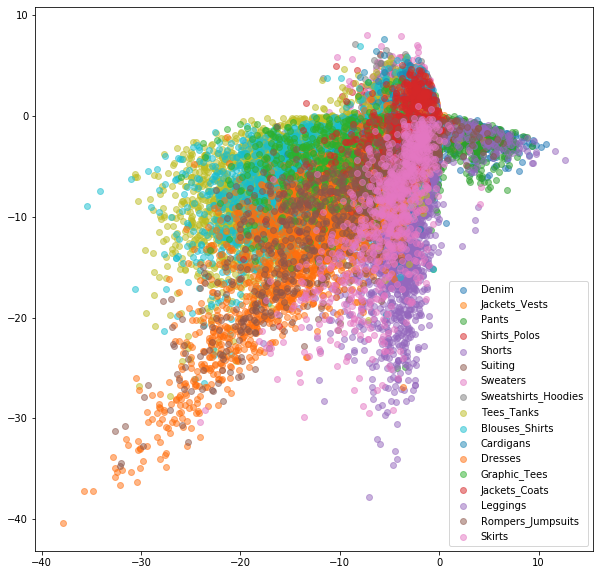

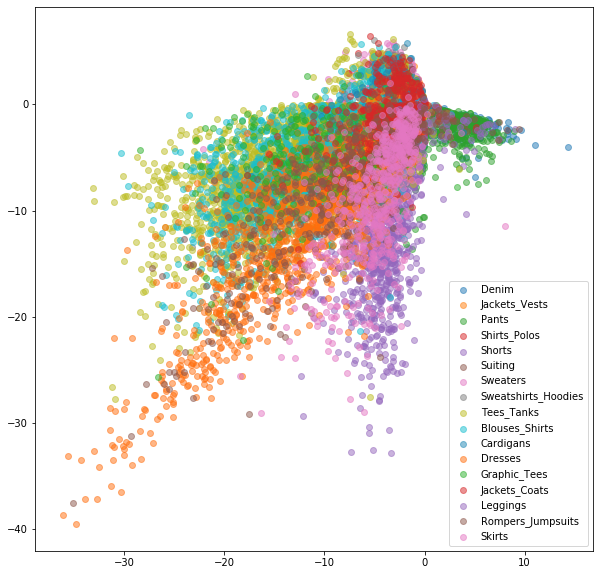

In [8]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_dataloader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(query_dataloader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Train classification and plot resulting embeddings for 16 dimensions embedding with PCA and t-SNE

In [7]:
embedding_net = MMFashionEmbeddingNet(out_dimensions=16)
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [9]:
from trainer import fit
fit(train_dataloader, gallery_dataloader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

Train: [0/25882 (0%)]	Loss: 2.815588	Accuracy: 3.125
Train: [3200/25882 (12%)]	Loss: 4.072393	Accuracy: 21.20098039215686
Train: [6400/25882 (25%)]	Loss: 2.296985	Accuracy: 24.922648514851485
Train: [9600/25882 (37%)]	Loss: 2.292657	Accuracy: 25.941639072847682
Train: [12800/25882 (49%)]	Loss: 2.264195	Accuracy: 26.267101990049753
Train: [16000/25882 (62%)]	Loss: 2.244129	Accuracy: 26.381972111553786
Train: [19200/25882 (74%)]	Loss: 2.213818	Accuracy: 26.66112956810631
Train: [22400/25882 (86%)]	Loss: 2.227558	Accuracy: 26.713853276353277
Train: [25600/25882 (99%)]	Loss: 2.187024	Accuracy: 26.878117206982544
Epoch: 1/20. Train set: Average loss: 2.4722	Accuracy: 26.902866857275328
Epoch: 1/20. Validation set: Average loss: 2.1924	Accuracy: 28.97031931354621
Train: [0/25882 (0%)]	Loss: 2.179122	Accuracy: 32.8125
Train: [3200/25882 (12%)]	Loss: 2.205392	Accuracy: 29.626225490196077
Train: [6400/25882 (25%)]	Loss: 2.244201	Accuracy: 28.774752475247524
Train: [9600/25882 (37%)]	Loss: 2.199

Train: [25600/25882 (99%)]	Loss: 1.682368	Accuracy: 41.13544264339152
Epoch: 11/20. Train set: Average loss: 1.7084	Accuracy: 41.15987945290163
Epoch: 11/20. Validation set: Average loss: 1.7831	Accuracy: 39.29525953017302
Train: [0/25882 (0%)]	Loss: 1.684957	Accuracy: 43.75
Train: [3200/25882 (12%)]	Loss: 1.701682	Accuracy: 40.83946078431372
Train: [6400/25882 (25%)]	Loss: 1.679829	Accuracy: 41.522277227722775
Train: [9600/25882 (37%)]	Loss: 1.664017	Accuracy: 41.65976821192053
Train: [12800/25882 (49%)]	Loss: 1.690471	Accuracy: 41.52674129353234
Train: [16000/25882 (62%)]	Loss: 1.699734	Accuracy: 41.73929282868526
Train: [19200/25882 (74%)]	Loss: 1.680175	Accuracy: 41.56976744186046
Train: [22400/25882 (86%)]	Loss: 1.698044	Accuracy: 41.54202279202279
Train: [25600/25882 (99%)]	Loss: 1.720252	Accuracy: 41.49781795511222
Epoch: 12/20. Train set: Average loss: 1.6919	Accuracy: 41.503747778378795
Epoch: 12/20. Validation set: Average loss: 1.7413	Accuracy: 40.35026023350682
Train: [0/25

# Plot resulting from classification training with 16 dimensions as output of embedding projected with PCA

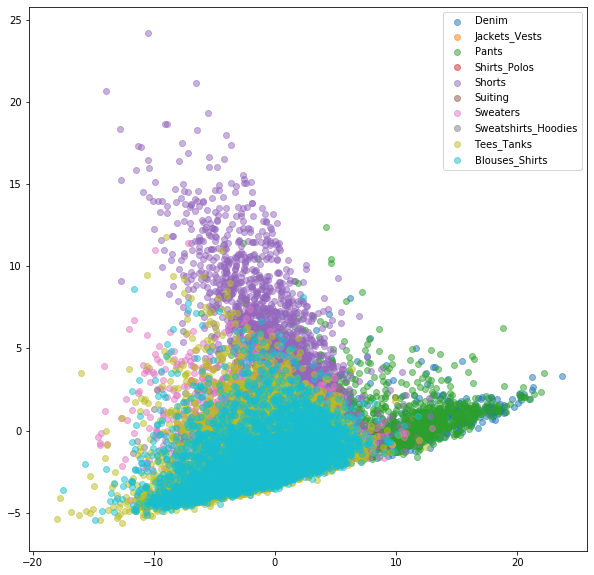

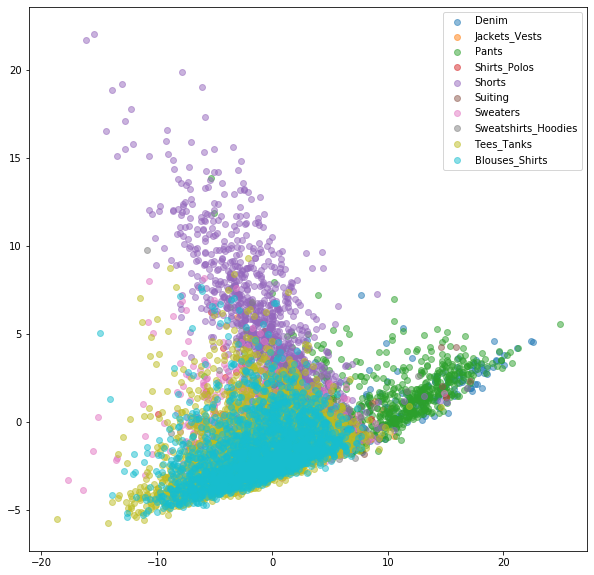

In [13]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_dataloader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline, transform='PCA')
val_embeddings_baseline, val_labels_baseline = extract_embeddings(query_dataloader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline, transform='PCA')

# Plot resulting from classification training with 16 dimensions as output of embedding projected with t-SNE

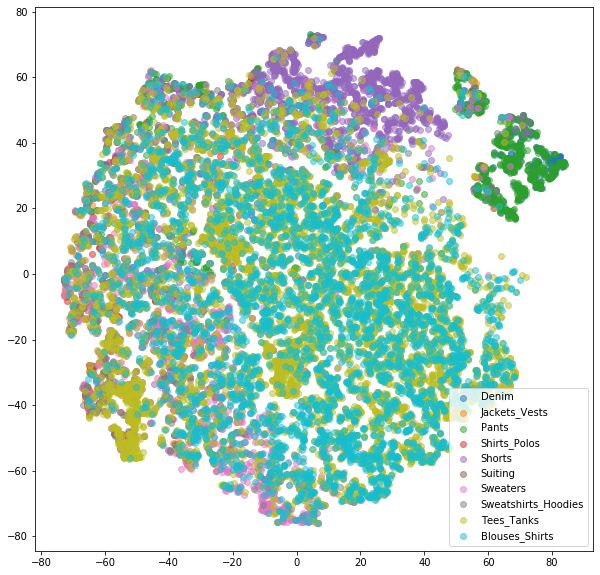

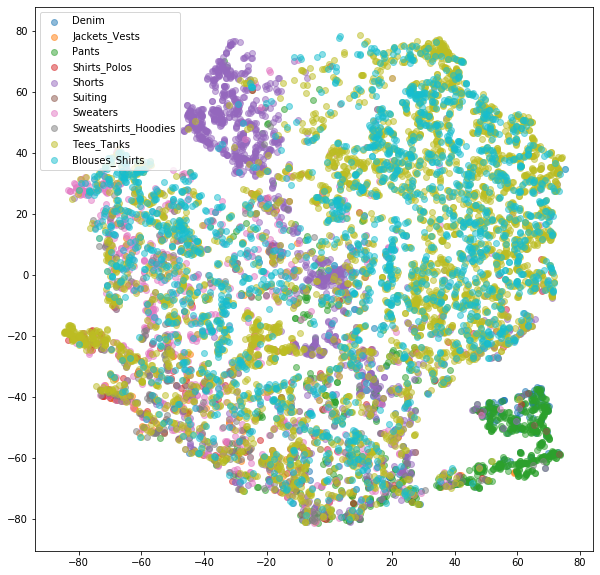

In [14]:
plot_embeddings(train_embeddings_baseline, train_labels_baseline, transform='TSNE')
plot_embeddings(val_embeddings_baseline, val_labels_baseline, transform='TSNE')

# Train classification and plot resulting embeddings for 32 dimensions embedding with PCA and t-SNE

In [ ]:
embedding_net = MMFashionEmbeddingNet(out_dimensions=32)
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

In [ ]:
from trainer import fit
fit(train_dataloader, gallery_dataloader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

# Plot resulting from classification training with 32 dimensions as output of embedding projected with PCA

In [ ]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_dataloader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline, transform='PCA')
val_embeddings_baseline, val_labels_baseline = extract_embeddings(query_dataloader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline, transform='PCA')

# Plot resulting from classification training with 32 dimensions as output of embedding projected with t-SNE

In [ ]:
plot_embeddings(train_embeddings_baseline, train_labels_baseline, transform='TSNE')
plot_embeddings(val_embeddings_baseline, val_labels_baseline, transform='TSNE')

# Train a metric learning model with Siamese Networks with 2 dimensions as output of embedding layer

In [6]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()
cuda = False
from datasets import SiameseMMFashion

# This are the datasets that will be used to load the pairs. It is done by a composition of an extended class from SiameseMNIST
# that uses In_shop dataset from mmfashion project, and is an adapter from one interface to siamese_triplet interface to seamlessly work
# in the training loop.
siamese_train_dataset = SiameseMMFashion(train_dataset, train=True) # Returns pairs of images and target same/different
siamese_gallery_dataset = SiameseMMFashion(gallery_dataset, train=False) 
siamese_query_dataset = SiameseMMFashion(query_dataset, train=False)
batch_size = 1
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_gallery_loader = torch.utils.data.DataLoader(siamese_gallery_dataset, batch_size=batch_size, shuffle=False, **kwargs)
siamese_query_loader = torch.utils.data.DataLoader(siamese_query_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# This is the embedding net that will be shared by the two branches of the siamese network. 
# MMFashionEmbeddingNet is an extension of EmbeddingNet to be adapted to the new type of input data
embedding_net = MMFashionEmbeddingNet(out_dimensions=2)
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 20

In [7]:
from trainer import fit
fit(siamese_train_loader, siamese_gallery_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

target 1
Image 1 img/WOMEN/Sweaters/id_00001700/02_4_full.jpg
Image 2 img/WOMEN/Sweaters/id_00002684/04_2_side.jpg
Train: [0/25882 (0%)]	Loss: 0.002067
target 1
Image 1 img/WOMEN/Tees_Tanks/id_00004489/04_3_back.jpg
Image 2 img/WOMEN/Tees_Tanks/id_00005561/01_1_front.jpg
target 0
Image 1 img/WOMEN/Cardigans/id_00000559/01_3_back.jpg
Image 2 img/WOMEN/Sweaters/id_00006080/06_2_side.jpg
target 0
Image 1 img/WOMEN/Tees_Tanks/id_00007757/01_2_side.jpg
Image 2 img/MEN/Sweatshirts_Hoodies/id_00006147/04_3_back.jpg
target 1
Image 1 img/WOMEN/Dresses/id_00007929/01_1_front.jpg
Image 2 img/WOMEN/Dresses/id_00003003/02_3_back.jpg
target 0
Image 1 img/WOMEN/Skirts/id_00005519/03_1_front.jpg
Image 2 img/WOMEN/Jackets_Coats/id_00006582/03_3_back.jpg
target 0
Image 1 img/WOMEN/Tees_Tanks/id_00002678/40_1_front.jpg
Image 2 img/WOMEN/Dresses/id_00005360/01_2_side.jpg
target 1
Image 1 img/MEN/Tees_Tanks/id_00003228/07_6_flat.jpg
Image 2 img/MEN/Tees_Tanks/id_00003685/01_1_front.jpg
target 1
Image 1 img

KeyboardInterrupt: 

# Plot resulting from siamese training with 2 dimensions as output of embedding

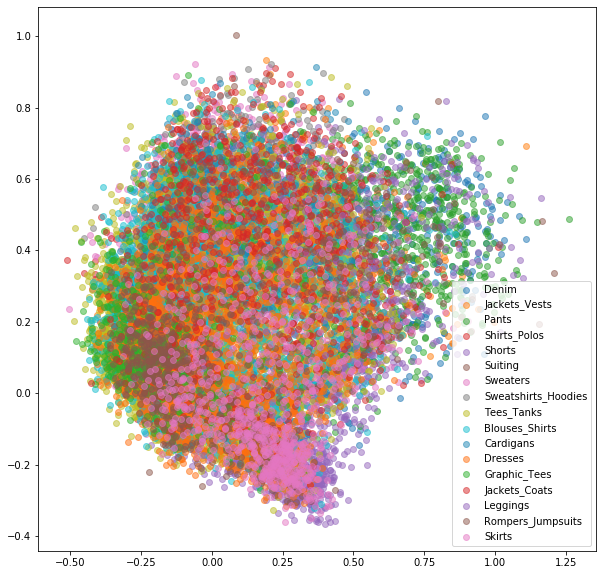

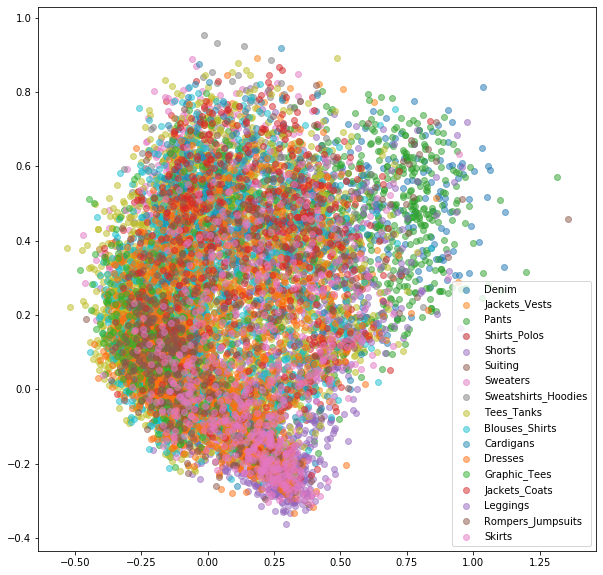

In [15]:
train_embeddings, train_labels = extract_embeddings(train_dataloader, model)
plot_embeddings(train_embeddings, train_labels)
val_embeddings, val_labels = extract_embeddings(query_dataloader, model)
plot_embeddings(val_embeddings, val_labels)

# Train a metric learning model with Triplet Networks with 2 dimensions as output of embedding layer

In [7]:
# Set up data loaders
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
from datasets import TripletMMFashion
cuda=False

triplet_train_dataset = TripletMMFashion(train_dataset, train=True) # Returns pairs of images and target same/different
triplet_gallery_dataset = TripletMMFashion(gallery_dataset, train=False) 
triplet_query_dataset = TripletMMFashion(query_dataset, train=False)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_gallery_loader = torch.utils.data.DataLoader(triplet_gallery_dataset, batch_size=batch_size, shuffle=False, **kwargs)
triplet_query_loader = torch.utils.data.DataLoader(triplet_query_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import MMFashionEmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = MMFashionEmbeddingNet(out_dimensions=2)
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

In [8]:
from trainer import fit
fit(triplet_train_loader, triplet_gallery_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Image 1 img/MEN/Shorts/id_00005609/04_2_side.jpg
Image 2 img/WOMEN/Shorts/id_00000596/04_7_additional.jpg
Image 3 img/WOMEN/Graphic_Tees/id_00003189/01_7_additional.jpg
Image 1 img/WOMEN/Shorts/id_00002453/01_3_back.jpg
Image 2 img/WOMEN/Shorts/id_00004000/01_3_back.jpg
Image 3 img/MEN/Shirts_Polos/id_00002461/01_2_side.jpg
Image 1 img/WOMEN/Sweatshirts_Hoodies/id_00003318/07_4_full.jpg
Image 2 img/MEN/Sweatshirts_Hoodies/id_00004338/01_3_back.jpg
Image 3 img/WOMEN/Skirts/id_00007606/02_1_front.jpg
Image 1 img/WOMEN/Sweaters/id_00004473/02_3_back.jpg
Image 2 img/WOMEN/Sweaters/id_00000533/06_2_side.jpg
Image 3 img/WOMEN/Skirts/id_00002961/02_1_front.jpg
Image 1 img/WOMEN/Dresses/id_00007241/04_2_side.jpg
Image 2 img/WOMEN/Dresses/id_00006248/02_2_side.jpg
Image 3 img/WOMEN/Cardigans/id_00000853/01_6_flat.jpg
Image 1 img/WOMEN/Sweaters/id_00000509/04_4_full.jpg
Image 2 img/WOMEN/Sweaters/id_00005720/05_7_additional.jpg
Image 3 img/WOMEN/Sweatshirts_Hoodies/id_00001464/01_7_additional.jp

Image 1 img/WOMEN/Blouses_Shirts/id_00006389/08_3_back.jpg
Image 2 img/WOMEN/Blouses_Shirts/id_00005535/08_2_side.jpg
Image 3 img/MEN/Denim/id_00001231/01_4_full.jpg
Image 1 img/WOMEN/Tees_Tanks/id_00004364/06_2_side.jpg
Image 2 img/WOMEN/Tees_Tanks/id_00004964/03_2_side.jpg
Image 3 img/WOMEN/Denim/id_00000274/01_1_front.jpg
Image 1 img/WOMEN/Blouses_Shirts/id_00004040/02_1_front.jpg
Image 2 img/WOMEN/Blouses_Shirts/id_00005696/02_2_side.jpg
Image 3 img/WOMEN/Rompers_Jumpsuits/id_00007057/02_1_front.jpg
Image 1 img/WOMEN/Blouses_Shirts/id_00005472/02_3_back.jpg
Image 2 img/WOMEN/Blouses_Shirts/id_00004202/02_7_additional.jpg
Image 3 img/MEN/Shirts_Polos/id_00003009/07_1_front.jpg
Image 1 img/WOMEN/Tees_Tanks/id_00004964/04_2_side.jpg
Image 2 img/WOMEN/Tees_Tanks/id_00004880/02_7_additional.jpg
Image 3 img/MEN/Sweatshirts_Hoodies/id_00006147/03_7_additional.jpg
Image 1 img/MEN/Pants/id_00000273/01_3_back.jpg
Image 2 img/MEN/Pants/id_00005690/02_7_additional.jpg
Image 3 img/WOMEN/Dresses

Image 1 img/WOMEN/Dresses/id_00007940/02_4_full.jpg
Image 2 img/WOMEN/Dresses/id_00005360/01_1_front.jpg
Image 3 img/WOMEN/Shorts/id_00005750/03_7_additional.jpg
Image 1 img/WOMEN/Tees_Tanks/id_00000834/02_2_side.jpg
Image 2 img/WOMEN/Tees_Tanks/id_00000401/05_7_additional.jpg
Image 3 img/WOMEN/Sweaters/id_00003285/04_1_front.jpg
Image 1 img/WOMEN/Pants/id_00004137/02_7_additional.jpg
Image 2 img/WOMEN/Pants/id_00000315/01_7_additional.jpg
Image 3 img/WOMEN/Blouses_Shirts/id_00003431/01_2_side.jpg
Image 1 img/WOMEN/Skirts/id_00007244/06_7_additional.jpg
Image 2 img/WOMEN/Skirts/id_00004791/06_2_side.jpg
Image 3 img/MEN/Suiting/id_00006233/01_2_side.jpg
Image 1 img/WOMEN/Dresses/id_00007965/01_1_front.jpg
Image 2 img/WOMEN/Dresses/id_00007794/02_1_front.jpg
Image 3 img/MEN/Tees_Tanks/id_00002381/04_2_side.jpg
Image 1 img/WOMEN/Tees_Tanks/id_00005618/03_7_additional.jpg
Image 2 img/MEN/Tees_Tanks/id_00001483/01_4_full.jpg
Image 3 img/WOMEN/Blouses_Shirts/id_00002384/02_4_full.jpg
Image 1

KeyboardInterrupt: 